&nbsp;

# 6. Final Pipeline  
A pipeline is a means of automating the machine learning workflow. What this means is that we can process and transform our data in a sequence of steps making the process of ingesting data, transforming it, and conducting predictions seamless. Also the pipeline itself can be used as an estimator, whether it's fitting data to it or making predictions. Another benefit of using pipelines aside from the obvious efficiency is that it automatically prevents data leakage from occurring (where our model learns something from the data).  

In [1]:
# Standard libraries. 
import pandas as pd
import numpy as np 
import os
import plotly.express as px

# Importing our functions. 
import functions
import visuals

# Importing chosen models. 
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Importing transformers.  
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, FunctionTransformer

# Importing pickle. 
from pickle import load

# Converts plotly output into static images, so it can be viewed inside github repository. 
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
root = os.getcwd() # Set up root directory.
trainData = pd.read_csv(r"{}\train.csv".format(root)) # Import train data. 
trainData = trainData.set_index("id") # Set paitent id as index. 

# Importing our holdout set that we set aside at the start. 
holdoutSet = pd.read_csv(r"{}\test.csv".format(root)) # Import data.  
holdoutSet = holdoutSet.set_index("id") # Set paitent id as index. 
holdoutSet.head(2)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
id,,,,,,,,,,,,,,,,,,,,,
84667401,13.73,22.61,93.60,578.3,0.11310,0.22930,0.212800,0.080250,0.2069,0.07682,...,32.01,108.80,697.7,0.1651,0.77250,0.69430,0.22080,0.3596,0.14310,1
897374,12.30,19.02,77.88,464.4,0.08313,0.04202,0.007756,0.008535,0.1539,0.05945,...,28.46,84.53,544.3,0.1222,0.09052,0.03619,0.03983,0.2554,0.07207,0


In [3]:
trainX = trainData.iloc[:,:-1] # Splitting our train features and label. 
trainy = trainData.iloc[:,-1]

testX = holdoutSet.iloc[:,:-1] # Splitting our holdout features and label. 
testy = holdoutSet.iloc[:,-1]

&nbsp;

### Section A: Evaluating on the Holdout Set
In this section we're finally going to evlauate model performance on the holdout set that we have separated from our dataset. Based on the results, we will pick the best performing model to use as our finalised pipeline. 

**A.1: Recall Score on the Holdoutset**<br>
First we'll create our pipeline with all of our transformers, train the estimator on our entire train dataset then use our estimator to predict our holdout set's labels using our optimal threshold value. We will do this over 30 iterations and store all results inside an empty list to later visualise.

In [4]:
scoresGBC = list()

GBC = functions.model_evaluation()
GBC.preprocessing(trainData)
GBC.add_pipe_component("n", Normalizer())
GBC.add_pipe_component("clf", GradientBoostingClassifier(learning_rate=0.1, max_depth=2, min_samples_split=30,
                                                    n_estimators=500, validation_fraction=0.2, n_iter_no_change=15, tol=0.1))

GBC.holdout_set_evaluation(scoresGBC, trainX, trainy, testX, testy,  0.454)

In [5]:
scoresRFC = list()

RFC = functions.model_evaluation()
RFC.preprocessing(trainData)
RFC.add_pipe_component("clf", RandomForestClassifier(max_depth=20, min_samples_split=10, min_samples_leaf=2, n_estimators=250))

RFC.holdout_set_evaluation(scoresRFC, trainX, trainy, testX, testy,  0.497)

In [6]:
scoresXGB = list()

XGB = functions.model_evaluation()
XGB.preprocessing(trainData)
XGB.add_pipe_component("n", Normalizer())
XGB.add_pipe_component("clf", XGBClassifier(learning_rate=0.1,max_depth=2, min_child_weight=1, n_estimators=69))

XGB.holdout_set_evaluation(scoresXGB, trainX, trainy, testX, testy,  0.648)

**A.2: Plotting the Recall Scores**<br> 
We will recursively predict the recall_score over 30 iterations and store the results inside an empty list. The objective is to see if there is any variance across all iterations, and to find the average scores to determine which model performed the best. We should also consider if any model shows too much volatility in their Recall score, then it might be better to choose the model with more consistent results.

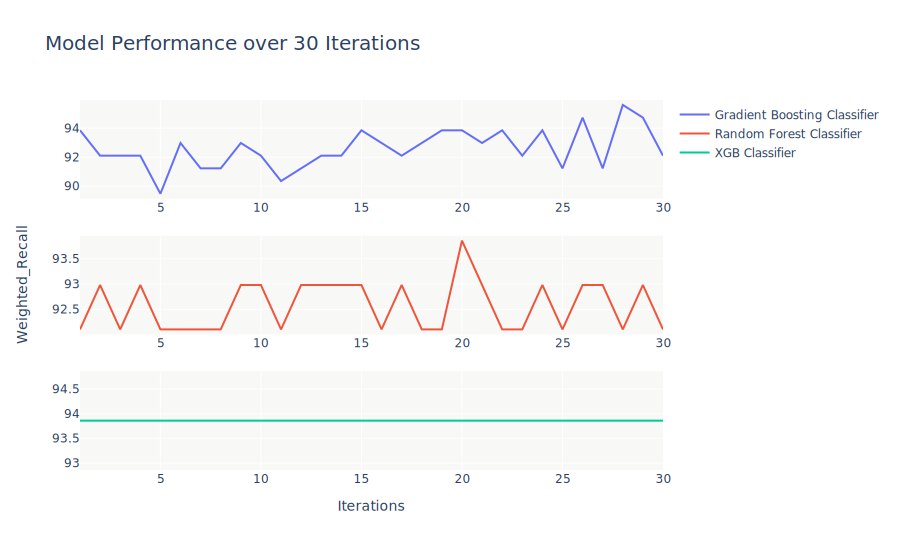

In [7]:
visuals.recall_plot(scoresGBC, scoresRFC, scoresXGB, "Weighted_Recall")

In [8]:
print("The average Weighted Recall over 30 iterations for Gradient Boosting Classifier is: %.4f%%" % (np.mean(scoresGBC)))
print("The average Weighted Recall over 30 iterations for Random Forest Classifier is: %.4f%%" % (np.mean(scoresRFC)))
print("The average Weighted Recall over 30 iterations for XGB Classifier is: %.4f%%" % (np.mean(scoresXGB)))

The average Weighted Recall over 30 iterations for Gradient Boosting Classifier is: 92.6023%
The average Weighted Recall over 30 iterations for Random Forest Classifier is: 92.5731%
The average Weighted Recall over 30 iterations for XGB Classifier is: 93.8596%


* Based on our results the best performing classifier with a weighted recall score of 93.86% was the XGB Classifier.
* What's interesting to note is that both the Gradient Boosting and Random Forest Classifiers had quite high variance through their predictions, while XG Boost remained fixed.

| Model | Model Type | Weighted Recall | 
|---------|---------|---------|
| **Gradient Boosting Classifier** | Normalized   |92.72% | 
| **Random Forest Classifier** | Base Model |92.57% |
| **XGB Classifier** | Normalized | 93.86% |

&nbsp;

### Section B: Saving & Loading the Model
In this section we're going to export our XGB Classifier into our current working directory, then load the model back in and make the same predictions again to see if everything saved correctly. 

**B.1: Saving and Exporting our Model as a Pickle File**<br>
Now it's time to save our pipeline estimator and export it as a pkl file into our current working directory.

In [9]:
functions.saving_model(trainX, trainy, XGBClassifier(learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=69))

**B.2: Loading our pickle File and Evaluation**<br>
The next part is to load our model back into the script and evaluate it again on the holdoutset. We run this again just to make sure that our entire pipeline components saved and loaded correctly and that our model has still retained its high performance.

In [10]:
# Loading our model back in. 
loaded_model = load(open("XGB_Classifier.pkl", "rb"))

**B.3: Predicting on the Holdoutset**<br>
Now it's time to validate the performance of our loaded model, and make sure it scores the same weighted_recall as our XGB Classifier above.

In [11]:
# Predicting probabilities on the Holdout set's features. 
yhat = loaded_model.predict_proba(testX)
# Keep probabilities for the positive outcome only.
probs = yhat[:, 1]
# Convert probabilities into classes based on specified threshold value. 
classes = functions.to_labels(probs, 0.648) # Input optimal LogisticRegression threshold. 

# Using f1_score "weighted" as the preferred metric for imbalanced classification. 
score = recall_score(testy, classes, average="weighted")*100
print(f"XGGB Classifier scored an f1_score of: %.4f%% on the holdout set." % (score))

XGGB Classifier scored an f1_score of: 93.8596% on the holdout set.


* Perfect, our model performed as expected.

&nbsp;

### Section C: Further Evaluation Metrics
In this section we're going to explore deeper into evaluating the performance of our Logistic Regression model by using the ROC AUC Curve and a Confusion Matrix.

**C.1: ROC AUC Curve**<br>
AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

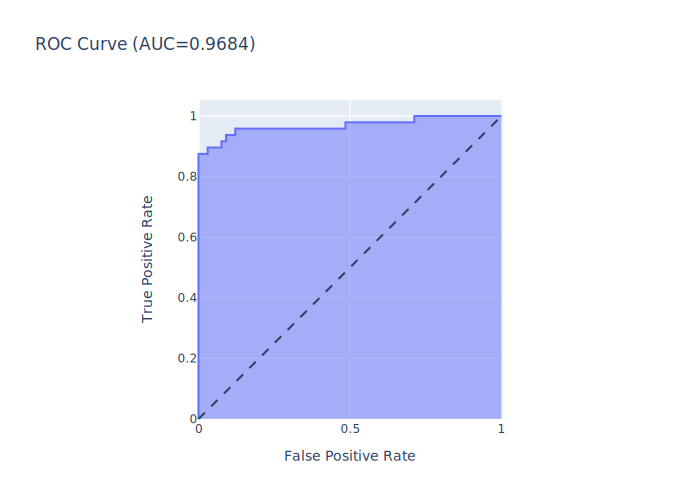

In [12]:
# Making predictions with our loaded model. 
yhat = loaded_model.predict_proba(testX)[:, 1]

# Plotting our ROC_AUC curve. 
functions.ROC_AUC_curve(testy, yhat)

* An AUC score of 1 means perfect class separability, while a score of 0.5 means the model is incapable of distinguishing between classes.
* Our AUC scored 0.9684 which is amazing. This means that our model can almost perfectly distingush classes.

**C.2: Confusion Matrix**<br>
A confusion matrix is a summary of how well a classification algorithm performed by outlining its correct and incorrect predictions.

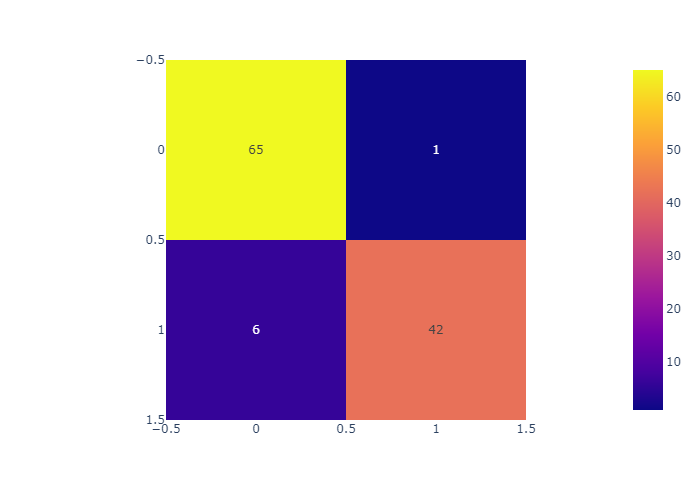

In [13]:
# Creating our confusion matrix from actuals vs predicted. 
cm = confusion_matrix(testy, classes)
# Plot results. 
fig = px.imshow(cm, text_auto=True)
fig.show(renderer="png") # The only way to show this chart inside github is to change render to png. 

In [14]:
# Extracting [True] positive, negative and [False] positive, negative from our confusion matrix.
tn, fp, fn, tp = confusion_matrix(list(testy), list(classes), labels=[0, 1]).ravel()

print('True Positive', tp)
print('True Negative', tn)
print('False Positive', fp)
print('False Negative', fn)

True Positive 42
True Negative 65
False Positive 1
False Negative 6


* There were 42 instances where our model predicted a class to be positive and it was actually positive.
* There were 65 instances where our model predicted a class to be negative and it was actually negative.
* There were 1 instances where our model predicted a class to be positive but it was actually negative.
* There were 6 instances where our model predicted a class to be negative but it was actually positive.

**C.3: Conclusion**<br>
In conclusion the model that achieved the highest weighted recall score on the holdout set was the XGB Classifier which scored  93.86% with no variance in the 30 predictions it conducted. Furthermore our classifier obtained an AUC score of 0.97 which indicates that it can almost perfectly distinguish between classes. 

However the one metric we care about in our confusion matrix is false negatives. This is when a predicted negative class was actually positive, so for e.g. imagine our algorithm predicting someone not having cancer, but they really did. Our Classifier resulted in 6 false negatives, which is not the worst, but there is definite room for improvement. 

&nbsp;

| Model | Model Type | Weighted Recall | Threshold |Hyperparameters |  
|---------|---------|---------|---------|---------|
| **Gradient Boosting Classifier** | Normalized   |92.72% | 0.454|learning_rate=0.1, max_depth=2, min_samples_split=30, n_estimators=500, <br>validation_fraction=0.2, n_iter_no_change=15, tol=0.1 |
| **Random Forest Classifier** | Base Model |92.57% |0.497 | max_depth=20, min_samples_split=10, min_samples_leaf=2,  n_estimators=250|
| **XGB Classifier** | Normalized | 93.86% |0.648 | learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=69|

&nbsp;

&nbsp;
**Author:** Aaron Chew&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Date Published:** 11/08/2022 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Email:** aaronsamuelchew@gmail.com &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **GitHub:** https://github.com/aaron-chew  